In [1]:
import numpy as np
import pandas as pd
import time
import random
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import torch
import tenseal as ts

In [2]:
# def find_minimum(array):
#     # Find the minimum value excluding zeros
#     non_zero_values = array[array != 0]
#     if len(non_zero_values) > 0:
#         return np.min(non_zero_values)
#     else:
#         return None

# minimum = find_minimum(x)
# print(minimum)

In [2]:
df = pd.read_csv(r"C:\Users\manig\Downloads\Mitacs\top_features.csv")
grouped = df.groupby('Label')
df = grouped.apply(lambda x: x.sample(grouped.size().min(), random_state=73).reset_index(drop=True))
x = df.drop(["Label"], axis = 1)
y = df["Label"]
# scaler = preprocessing.MinMaxScaler()
# scaler = preprocessing.QuantileTransformer()
scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(x)
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.20, random_state=42)
x_val, x_test_20, y_val, y_test_20 = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
x_train=torch.from_numpy(x_train).float()
x_val=torch.from_numpy(x_val).float()
x_test_20=torch.from_numpy(x_test_20).float()
y_train=torch.from_numpy(np.array(y_train)).float().unsqueeze(1)
y_val=torch.from_numpy(np.array(y_val)).float().unsqueeze(1)
y_test_20=torch.from_numpy(np.array(y_test_20)).float().unsqueeze(1)
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test_20.shape}")
print(f"y_test shape: {y_test_20.shape}")

x_train shape: torch.Size([681185, 30])
y_train shape: torch.Size([681185, 1])
x_val shape: torch.Size([85148, 30])
y_val shape: torch.Size([85148, 1])
x_test shape: torch.Size([85149, 30])
y_test shape: torch.Size([85149, 1])


In [3]:
del grouped, df, x, y

In [4]:
class LR(torch.nn.Module):

    def __init__(self, n_features):
        super(LR, self).__init__()
        self.lr = torch.nn.Linear(n_features, 1)
        
    def forward(self, x):
        out = torch.sigmoid(self.lr(x))
        return out

In [6]:
def validate(model, criterion, x_val, y_val):
    model.eval()  
    with torch.no_grad():  
        outputs = model(x_val)
        loss = criterion(outputs, y_val)
        acc, _ = accuracy(model, x_val, y_val)
    model.train()  
    return loss.item(), acc

In [7]:
def train(model, optimizer, criterion, x, y, x_val, y_val, epochs):
    train_loss_dict = {}
    train_acc_dict = {}
    val_loss_dict = {}
    val_acc_dict = {}
    for e in range(1, epochs + 1):
        def closure():
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            return loss
        optimizer.step(closure)
#         scheduler.step(closure().item())
        train_loss = closure().item()
        train_loss_dict[e] = train_loss
        train_acc, _ = accuracy(model, x, y)
        train_acc_dict[e] = train_acc
        val_loss, val_acc = validate(model, criterion, x_val, y_val)
        val_loss_dict[e] = val_loss
        val_acc_dict[e] = val_acc
        if e%50 == 0:
            print(f"Epoch {e} - Training loss: {train_loss}, Training accuracy: {train_acc}, Validation loss: {val_loss}, Validation accuracy: {val_acc}, Learning Rate: {optimizer.param_groups[0]['lr']}\n")
    return model, train_loss_dict, train_acc_dict, val_loss_dict, val_acc_dict

In [8]:
def accuracy(model, x, y, train=True):
    out_list = []
    t_start = time.time()
    out = model(x)
    t_end = time.time()
    if(train==False):
        print(f"Prediction Time: {(t_end - t_start)} seconds")
    out_list.append(out)
    correct = torch.abs(y - out) < 0.5
    return correct.float().mean(), out

Epoch 50 - Training loss: 0.20990997552871704, Training accuracy: 0.9234334230422974, Validation loss: 0.2119133025407791, Validation accuracy: 0.9239559173583984, Learning Rate: 0.001

Epoch 100 - Training loss: 0.20727108418941498, Training accuracy: 0.9258674383163452, Validation loss: 0.21026445925235748, Validation accuracy: 0.9258584976196289, Learning Rate: 0.001

Epoch 150 - Training loss: 0.20681239664554596, Training accuracy: 0.9241263270378113, Validation loss: 0.2090817540884018, Validation accuracy: 0.9239206910133362, Learning Rate: 0.001

Epoch 200 - Training loss: 0.2069191187620163, Training accuracy: 0.9240558743476868, Validation loss: 0.20905396342277527, Validation accuracy: 0.9239324331283569, Learning Rate: 0.001

Epoch 250 - Training loss: 0.20678727328777313, Training accuracy: 0.9239927530288696, Validation loss: 0.2090412676334381, Validation accuracy: 0.9238502383232117, Learning Rate: 0.001

Epoch 300 - Training loss: 0.20678101480007172, Training accuracy

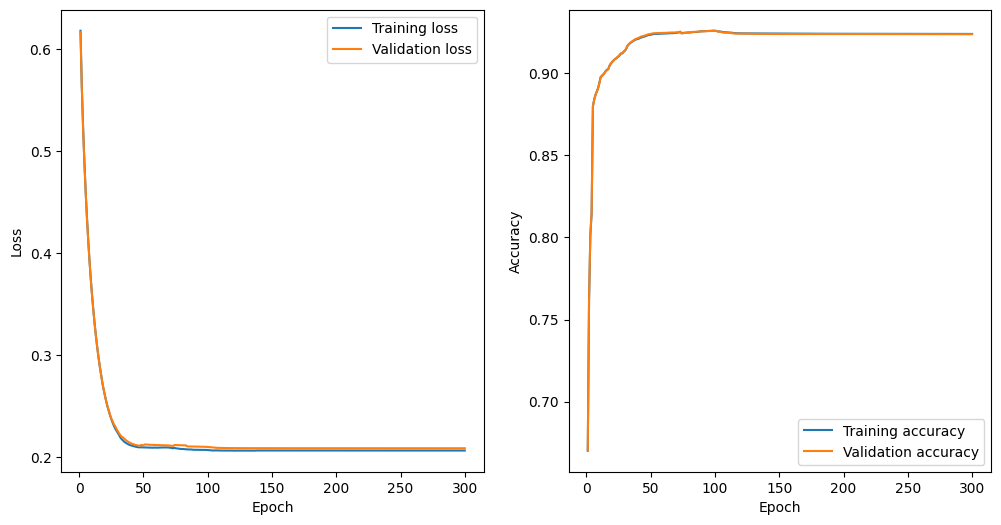

In [24]:
n_features = x_train.shape[1]
torch.random.manual_seed(42)
random.seed(42)
model = LR(n_features)
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.001, max_iter=100)
criterion = torch.nn.BCELoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)
EPOCHS = 300

t_start = time.time()
model, train_loss_dict, train_acc_dict, val_loss_dict, val_acc_dict  = train(model, optimizer, criterion, x_train, y_train, x_val, y_val, EPOCHS)
t_end = time.time()
print(f"Training Time: {int(t_end - t_start)} seconds")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(*zip(*train_loss_dict.items()), label='Training loss')
ax1.plot(*zip(*val_loss_dict.items()), label='Validation loss')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(*zip(*train_acc_dict.items()), label='Training accuracy')
ax2.plot(*zip(*val_acc_dict.items()), label='Validation accuracy')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()
plt.show()

In [25]:
out_list = []
plain_accuracy, op = accuracy(model, x_test_20, y_test_20)
print(f"Accuracy on plain test_set: {plain_accuracy}")

Accuracy on plain test_set: 0.9221482276916504


In [5]:
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "lr.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [39]:
# print(f"Saving model to: {MODEL_SAVE_PATH}")
# torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH) 

Saving model to: models\lr.pth


In [6]:
model = LR(30)
model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [29]:
op_df = pd.DataFrame({
    "Original": op.squeeze().detach().numpy()})
op_df.head()

,Original
0,0.000965
1,0.107859
2,0.999993
3,0.002897
4,0.999975


In [30]:
op = op.squeeze().detach().numpy()
for i in range(len(op)):
    if op[i]<0.5:
        op[i] = 0
    else:
        op[i] = 1
y_test_temp = y_test_20.squeeze().numpy()
plain_accuracy = accuracy_score(y_test_temp, op)
plain_recall = recall_score(y_test_temp, op, average='binary')  
plain_f1 = f1_score(y_test_temp, op, average='binary')  
plain_precision = precision_score(y_test_temp, op, average='binary')  
print(f"Accuracy: {plain_accuracy}")
print(f"Recall: {plain_recall}")
print(f"Precision: {plain_precision}")
print(f"F1 - Score: {plain_f1}")

Accuracy: 0.9221482342716885
Recall: 0.9659731354499342
Precision: 0.8881571844974631
F1 - Score: 0.9254322320836006


In [7]:
class EncryptedLR:
    
    def __init__(self, torch_lr):
        self.weight = torch_lr.lr.weight.data.tolist()[0]
        self.bias = torch_lr.lr.bias.data.tolist()
        
    def forward(self, enc_x):
        enc_out = enc_x.dot(self.weight) + self.bias
        return enc_out
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
    
    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)
        
    def decrypt(self, context):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()
        
eelr = EncryptedLR(model)

In [8]:
poly_mod_degree = 8192
coeff_mod_bit_sizes = [60, 40, 60]
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
ctx_eval.global_scale = 2 ** 40
ctx_eval.generate_galois_keys()

In [33]:
# eelr.encrypt(ctx_eval)

In [9]:
def encrypted_evaluation(model, enc_x_test, y_test):
    t_start = time.time()
    output_list = []
    correct = 0
    for enc_x, y in zip(enc_x_test, y_test):
        enc_out = model(enc_x)
        out = enc_out.decrypt()
        out = torch.tensor(out)
        out = torch.sigmoid(out)
        if torch.abs(out - y) < 0.5:
            correct += 1
        output_list.append(out)
    t_end = time.time()
    print(f"Evaluated test set of {len(enc_x_test)} entries in {int(t_end - t_start)} seconds")
    print(f"Score: {correct}/{len(enc_x_test)}")
    return correct / len(enc_x_test), output_list

In [10]:
y_pred_final = []
one_part = y_test_20.shape[0] // 20
for i in range(1, 21):
    if i==1:
        j = one_part
        temp_x_test = x_test_20[:j,]
        temp_y_test = y_test_20[:j,]
    elif i==20:
        j = one_part * (i-1)
        temp_x_test = x_test_20[j:,]
        temp_y_test = y_test_20[j:,]
    else:
        j = one_part * i
        if i == 1:
            k = one_part
        else:
            k = one_part * (i-1)
        temp_x_test = x_test_20[k:j,]
        temp_y_test = y_test_20[k:j,]
    
    t_start = time.time()
    enc_x_test = []
    print(f"Starting Batch {i} Encryption")
    for x in tqdm(range(len(temp_x_test))):
        enc_x_test.append(ts.ckks_vector(ctx_eval, temp_x_test[x].tolist()))
    t_end = time.time()
    print(f"Encryption of the test set took {int(t_end - t_start)} seconds")
    encrypted_accuracy, output_list = encrypted_evaluation(eelr, enc_x_test, temp_y_test)
    print(f"Batch {i} Encrypted Accuracy: {encrypted_accuracy}")
    y_pred = torch.cat(output_list)
    y_pred = y_pred.numpy()
    y_pred_final.extend(y_pred)

Starting Batch 1 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:20<00:00, 211.27it/s]


Encryption of the test set took 20 seconds
Evaluated test set of 4257 entries in 64 seconds
Score: 3917/4257
Batch 1 Encrypted Accuracy: 0.9201315480385248
Starting Batch 2 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:20<00:00, 209.64it/s]


Encryption of the test set took 20 seconds
Evaluated test set of 4257 entries in 62 seconds
Score: 3908/4257
Batch 2 Encrypted Accuracy: 0.9180173831336622
Starting Batch 3 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:18<00:00, 232.78it/s]


Encryption of the test set took 18 seconds
Evaluated test set of 4257 entries in 59 seconds
Score: 3937/4257
Batch 3 Encrypted Accuracy: 0.9248296922715528
Starting Batch 4 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:17<00:00, 238.83it/s]


Encryption of the test set took 17 seconds
Evaluated test set of 4257 entries in 54 seconds
Score: 3933/4257
Batch 4 Encrypted Accuracy: 0.9238900634249472
Starting Batch 5 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:17<00:00, 246.67it/s]


Encryption of the test set took 17 seconds
Evaluated test set of 4257 entries in 53 seconds
Score: 3960/4257
Batch 5 Encrypted Accuracy: 0.9302325581395349
Starting Batch 6 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:17<00:00, 247.46it/s]


Encryption of the test set took 17 seconds
Evaluated test set of 4257 entries in 53 seconds
Score: 3930/4257
Batch 6 Encrypted Accuracy: 0.923185341789993
Starting Batch 7 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:17<00:00, 247.70it/s]


Encryption of the test set took 17 seconds
Evaluated test set of 4257 entries in 53 seconds
Score: 3888/4257
Batch 7 Encrypted Accuracy: 0.9133192389006343
Starting Batch 8 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:17<00:00, 247.32it/s]


Encryption of the test set took 17 seconds
Evaluated test set of 4257 entries in 53 seconds
Score: 3899/4257
Batch 8 Encrypted Accuracy: 0.9159032182287996
Starting Batch 9 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:17<00:00, 247.20it/s]


Encryption of the test set took 17 seconds
Evaluated test set of 4257 entries in 53 seconds
Score: 3920/4257
Batch 9 Encrypted Accuracy: 0.920836269673479
Starting Batch 10 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:17<00:00, 248.10it/s]


Encryption of the test set took 17 seconds
Evaluated test set of 4257 entries in 52 seconds
Score: 3902/4257
Batch 10 Encrypted Accuracy: 0.9166079398637538
Starting Batch 11 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:17<00:00, 248.62it/s]


Encryption of the test set took 17 seconds
Evaluated test set of 4257 entries in 52 seconds
Score: 3937/4257
Batch 11 Encrypted Accuracy: 0.9248296922715528
Starting Batch 12 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:17<00:00, 248.37it/s]


Encryption of the test set took 17 seconds
Evaluated test set of 4257 entries in 53 seconds
Score: 3959/4257
Batch 12 Encrypted Accuracy: 0.9299976509278834
Starting Batch 13 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:17<00:00, 247.86it/s]


Encryption of the test set took 17 seconds
Evaluated test set of 4257 entries in 53 seconds
Score: 3923/4257
Batch 13 Encrypted Accuracy: 0.9215409913084331
Starting Batch 14 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:17<00:00, 249.12it/s]


Encryption of the test set took 17 seconds
Evaluated test set of 4257 entries in 53 seconds
Score: 3938/4257
Batch 14 Encrypted Accuracy: 0.9250645994832042
Starting Batch 15 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:17<00:00, 248.03it/s]


Encryption of the test set took 17 seconds
Evaluated test set of 4257 entries in 52 seconds
Score: 3925/4257
Batch 15 Encrypted Accuracy: 0.922010805731736
Starting Batch 16 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:17<00:00, 247.92it/s]


Encryption of the test set took 17 seconds
Evaluated test set of 4257 entries in 52 seconds
Score: 3934/4257
Batch 16 Encrypted Accuracy: 0.9241249706365986
Starting Batch 17 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:17<00:00, 249.26it/s]


Encryption of the test set took 17 seconds
Evaluated test set of 4257 entries in 52 seconds
Score: 3938/4257
Batch 17 Encrypted Accuracy: 0.9250645994832042
Starting Batch 18 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:17<00:00, 248.51it/s]


Encryption of the test set took 17 seconds
Evaluated test set of 4257 entries in 53 seconds
Score: 3926/4257
Batch 18 Encrypted Accuracy: 0.9222457129433873
Starting Batch 19 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4257/4257 [00:17<00:00, 246.88it/s]


Encryption of the test set took 17 seconds
Evaluated test set of 4257 entries in 52 seconds
Score: 3932/4257
Batch 19 Encrypted Accuracy: 0.9236551562132957
Starting Batch 20 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 4266/4266 [00:17<00:00, 247.41it/s]


Encryption of the test set took 17 seconds
Evaluated test set of 4266 entries in 52 seconds
Score: 3914/4266
Batch 20 Encrypted Accuracy: 0.9174871073605251


In [11]:
for i in range(len(y_pred_final)):
    if y_pred_final[i]<0.5:
        y_pred_final[i] = 0
    else:
        y_pred_final[i] = 1
y_test_temp = y_test_20.squeeze().numpy()
enc_accuracy = accuracy_score(y_test_temp, y_pred_final)
enc_recall = recall_score(y_test_temp, y_pred_final, average='binary')
enc_f1 = f1_score(y_test_temp, y_pred_final, average='binary')
enc_precision = precision_score(y_test_temp, y_pred_final, average='binary')
print(f"Accuracy: {enc_accuracy}")
print(f"Recall: {enc_recall}")
print(f"Precision: {enc_precision}")
print(f"F1 - Score: {enc_f1}")

Accuracy: 0.9221482342716885
Recall: 0.9659731354499342
Precision: 0.8881571844974631
F1 - Score: 0.9254322320836006
